In [41]:
import joblib
import math
import numpy as np
import os
import pandas as pd

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import ( accuracy_score, f1_score, r2_score, mean_squared_error )
from sklearn.model_selection import ( GridSearchCV, train_test_split )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import( OneHotEncoder, StandardScaler, LabelEncoder )
from sklearn.utils import shuffle

In [42]:
numVotes = [200, 20000]
duree = [40, 150]
year = [1930, 2017]
genre = 8
parentalAdvisor = 5

In [43]:
dataset = pd.read_csv(r'src/dataset.csv', delimiter=',', on_bad_lines='skip')

corr_matrix = round(dataset.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )

fig.show()

# numVotes

In [44]:
print(len(dataset))

dfnumVotes = dataset.sort_values(by=['numVotes'])

dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] < numVotes[1]]
dfnumVotes = dfnumVotes[dfnumVotes['numVotes'] > numVotes[0]]

print(len(dfnumVotes))

px.histogram(dfnumVotes["numVotes"])

88648
47417


# duree

In [45]:
dfduree = dfnumVotes.sort_values(by=['duree'])
dfduree = dfduree[dfduree['duree'] < duree[1]]
dfduree = dfduree[dfduree['duree'] > duree[0]]



print(len(dfduree))

px.histogram(dfduree["duree"])

45780


# year

In [46]:
dfyear = dfduree.sort_values(by=['year'])
dfyear = dfyear[dfyear['year'] < year[1]]
dfyear = dfyear[dfyear['year'] > year[0]]

print(len(dfyear))

px.histogram(dfyear["year"])

38592


# genre

29239


<AxesSubplot:>

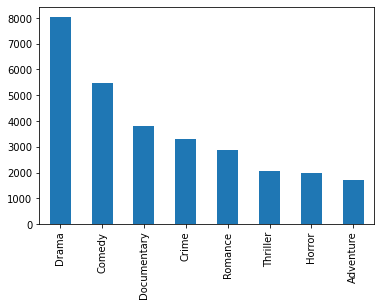

In [47]:
dfgenre = dfyear
countGenre = dfgenre['genre'].value_counts()
countGenre = countGenre[countGenre[:] > countGenre[genre] ]
listGenre = countGenre.keys().tolist()

dfgenre = dfgenre[dfgenre['genre'].isin(listGenre)]

print(len(dfgenre))

countGenre.plot(kind='bar')

# parentalAdvisor

Not Rated    8316
R            7877
PG           2096
Approved     2031
PG-13        1904
Name: parentalAdvisor, dtype: int64
22224


<AxesSubplot:>

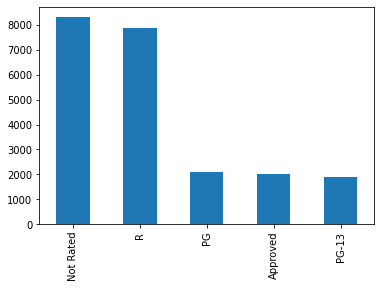

In [48]:
dfparentalAdvisor = dfgenre
countAdvisor = dfparentalAdvisor['parentalAdvisor'].value_counts()

countAdvisor = countAdvisor[countAdvisor[:] > countAdvisor[parentalAdvisor] ] # Drop Less than 5% of biggest genre.
print(countAdvisor)
listGenre = countAdvisor.keys().tolist()

dfparentalAdvisor = dfparentalAdvisor[dfparentalAdvisor['parentalAdvisor'].isin(listGenre)]

print(len(dfparentalAdvisor))

countAdvisor.plot(kind='bar')

# imdbRating

In [49]:
dfimdbRating = dfparentalAdvisor.sort_values(by=['imdbRating'])

print(len(dfimdbRating))

px.histogram(dfimdbRating["imdbRating"])

22224


# Drop Lines 

In [50]:
datasetWithoutOutlier = dfimdbRating.drop(columns=['tconst', 'numVotes', 'themaScore'])
datasetWithoutOutlier = shuffle(datasetWithoutOutlier)

In [51]:
target_name = 'imdbRating'

## Graph de correlation 

In [52]:


corr_matrix = round(datasetWithoutOutlier.corr(), 4)

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.values.tolist(),
                                  y = corr_matrix.index.values.tolist(),
                                  )


fig.show()

## Separation Varibles / Target

In [53]:
## Separation valeurs explicative et valeur cible
Y = datasetWithoutOutlier[:][target_name]
X = datasetWithoutOutlier.drop(columns= [target_name])

## Separation en train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0, stratify=X['genre'])
# stratify = Y # option pour même ratio de réponse que sur la table Y.
print(X)
print(Y)

       year        genre parentalAdvisor  duree
86396  2009       Comedy       Not Rated   71.0
77968  2015        Drama       Not Rated   84.0
4066   2011  Documentary       Not Rated  145.0
64422  1995       Comedy           PG-13   86.0
69688  2004       Comedy              PG  111.0
...     ...          ...             ...    ...
81296  1991        Drama               R  102.0
64960  2010        Crime               R  111.0
80191  2000        Drama               R  108.0
35707  1969        Crime           PG-13  105.0
52076  1997        Drama               R   97.0

[22224 rows x 4 columns]
86396    6.4
77968    6.2
4066     6.5
64422    4.1
69688    7.1
        ... 
81296    6.6
64960    5.4
80191    4.8
35707    5.4
52076    6.5
Name: imdbRating, Length: 22224, dtype: float64


## Pipeline Préprocessor 

In [54]:
## Médiane quantitative & plus fréquent qualitatif



# Create pipeline for numeric features
numeric_features = X.select_dtypes([np.number]).columns # Automatically detect positions of numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # missing values will be replaced by columns' median
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = X.select_dtypes("object").columns # Automatically detect positions of categorical columns
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_train = preprocessor.fit_transform(X_train) # Preprocessing influenceur
X_test = preprocessor.transform(X_test) # Preprocessing copieur


## Training
### Random Forest

In [55]:
model = RandomForestRegressor(n_jobs=-1, verbose=2) 
# n_jobs=-1 -> Utilisation de tout les cores 
# verbose=2 -> Affiche toutes les info de constructions

## Prediction
### Random Forest model : Grid search

In [56]:

# Grid of values to be tested

params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [10, 20, 40, 60, 80, 100]
}
'''
params = {
    'max_depth': [4, 6, 8, 10, 12, 14],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 5, 7, 10],
    'min_samples_split': [2, 4, 8, 16, 32, 64],
    'n_estimators': [10, 20, 40, 60, 80, 100, 200]
}
'''
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
# 36m 6.5s 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Paralle

building tree 1 of 100
building tree 2 of 100building tree 3 of 100
building tree 4 of 100building tree 5 of 100
building tree 6 of 100


building tree 7 of 100building tree 8 of 100

building tree 9 of 100
building tree 10 of 100building tree 11 of 100

building tree 12 of 100building tree 13 of 100building tree 14 of 100
building tree 15 of 100

building tree 16 of 100

building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100building tree 22 of 100

building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100building tree 27 of 100

building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100building tree 35 of 100

building tree 36 of 100
building tree 37 of 100
building tree 38 of 100building tree 39 of 100

building tree 40 of 100
building tree 41 of 100
building tree 42 of 100bu

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    0.3s


building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100building tree 53 of 100
building tree 54 of 100

building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100building tree 59 of 100

building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100building tree 68 of 100

building tree 69 of 100
building tree 70 of 100building tree 71 of 100

building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76 of 100
building tree 77 of 100
building tree 78 of 100
building tree 79 of 100
building tree 80 of 100
building tree 81 of 100
building tree 82 of 100
building tree 83 of 100
building tree 84 of 100
building tree 85 of 100
building tree 86 of 100
building tree 87 of 100
building tree 88 of 100
building tree 89 of 100
building tree 90

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.1s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, verbose=2),
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [10, 20, 40, 60, 80, 100]})

In [57]:
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)

...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 4, 'n_estimators': 100}


In [58]:
Y_train_pred = gridsearch.predict(X_train) # Predictions on training set
Y_test_pred = gridsearch.predict(X_test) # Prédictions on test set 

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


#### Grid search : Random Forest

In [59]:
# Compute mean squared error
mse = mean_squared_error(Y_test, Y_test_pred)
print("Mean squared error : ", mse)
print("Mean error : ", mse**0.5)


Mean squared error :  1.2016479356815761
Mean error :  1.0961970332388133


In [60]:
print(f'Number of votes min : {numVotes[0]}, max : {numVotes[1]}')
print(f'Duration min : {duree[0]}, max : {duree[1]}')
print(f'From {year[0]} to {year[1]}')
print(f'{genre} best genres selected')
print(f'{parentalAdvisor} best advisory selected')


fig = px.scatter(x = Y_test, y = Y_test_pred, opacity=0.2, trendline="lowess", width=650, height=600, marginal_y='violin')
fig.update_layout( margin=dict(l=20, r=10, t=10, b=10), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

Number of votes min : 200, max : 20000
Duration min : 40, max : 150
From 1930 to 2017
8 best genres selected
5 best advisory selected


In [61]:
def ecartExponantiel(chiffre, moyenne): 
    returnValue = moyenne

    if chiffre == moyenne:
        returnValue = chiffre

    elif chiffre > moyenne:
        ecart = chiffre-moyenne
        logy = math.log1p( ecart + 1) 
        returnValue = chiffre + (ecart * logy)

    else :
        ecart = moyenne-chiffre
        logy = math.log1p( ecart + 1)
        
        returnValue = chiffre - (ecart * logy)

    if returnValue > 10:
        return 10
    elif returnValue < 0:
        return 0
    else:
        return returnValue

In [62]:
fig = px.scatter(x = Y_test, y = Y_test, opacity=0.2, width=650, height=600, marginal_y='violin')
fig.update_layout( margin=dict(l=20, r=10, t=10, b=10), yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

In [63]:
Y_test_pred2 = np.array([ecartExponantiel(num,Y_test_pred.mean()) for num in Y_test_pred])

# Compute mean squared error
mse = mean_squared_error(Y_test, Y_test_pred2)
print("Mean squared error : ", mse)
print("Mean error : ", mse**0.5)

# ['lowess', 'rolling', 'ewm', 'expanding', 'ols']

fig = px.scatter(x = Y_test, y = Y_test_pred2, opacity=0.2, trendline="lowess", width=600, height=600)
fig.update_layout( 
    margin=dict(l=20, r=10, t=10, b=10),
    xaxis=go.layout.XAxis(range=[0, 10]),
    yaxis=go.layout.YAxis(range=[0, 10]),

)
fig.show()

Mean squared error :  1.6018692830527477
Mean error :  1.265649747383828


## Save Model

In [64]:
# save
# joblib.dump(gridsearch.best_estimator_, "export/random_forest.joblib", compress=3)